# Generalized (Kernel) Fisherface Parameter Evaluation ($\alpha, \beta$)

This notebook evaluates Generalized Kernel Fisherface and Generalized Fisherface on a range of the parameters $\alpha, \beta$

## Set up

In [1]:
import numpy as np
import sklearn.pipeline
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [2]:
# load data
import sklearn.datasets
from sklearn.model_selection import train_test_split


lfw_people = sklearn.datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4)

n_samples, h, w = lfw_people.images.shape
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target


print("Total dataset size:")
print("n_samples: ",  n_samples)
print("n_features: ", n_features)
print("n_classes: ", n_classes)

Total dataset size:
n_samples:  1288
n_features:  1850
n_classes:  7


In [3]:
def create_data_split(X, y, test_size=0.2, random_state=None):
    '''creates a train-test split and performs preprocessing'''

    # split into a training and testing set
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # first, scale the data
    scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
    X_train_trfm = scaler.transform(X_train)
    X_test_trfm = scaler.transform(X_test)

    return X_train_trfm, X_test_trfm, y_train, y_test

In [4]:
def plot_faces(faces, n_cols=3, figsize=(8,6), h=h, w=w):

    dim, n_faces = faces.shape
    n_rows = n_faces // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(faces[:, i].reshape(h,w))

    return fig, ax

In [5]:
from generalized_fisher_ld import GeneralizedFisherLD
from generalized_kernel_fisher_discriminant import GeneralizedKernelFisherLD

## Parameter Evaluation

Here, we evaluate the model on different choices for the parameters $(\alpha, \beta)$ along the line $\alpha=\beta$

In [6]:
num_alpha_beta = 21 # number of values for alpha=beta to test. control the resolution of the 'alpha=beta axis'
num_trials = 20 # the number of trials (with different data splits) to try on each value of alpha=beta

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier # the classifier to use in the model
classifier_params = {'n_neighbors': 3} # the parameters to pass into the classifier

In [7]:
alpha_betas = np.linspace(0,1, num=num_alpha_beta)

In [8]:
# Generalized Fisher LD
from tqdm.notebook import tqdm, trange

train_accs = np.zeros(shape=(num_alpha_beta, num_trials))
test_accs = np.zeros(shape=(num_alpha_beta, num_trials))

for i, alpha_beta in enumerate(tqdm(alpha_betas, desc='alpha_beta')):
    alpha = beta = alpha_beta

    for trial in trange(num_trials, desc='trial', leave=False):

        # create data split
        X_train_trfm, X_test_trfm, y_train, y_test = create_data_split(X, y, test_size=0.2)

        n_samples_train = len(X_train_trfm)
        n_classes = len(np.unique(y_train))

        # train model

        # if alpha=beta=0 (standard fisherface, need to do pca first)
        if alpha == beta == 0:
            fld_clf = sklearn.pipeline.Pipeline(steps=[('pca', PCA(n_components = n_samples_train - n_classes)),
                                            ('gfld', GeneralizedFisherLD(n_components=n_classes - 1, alpha=0, beta=0)),
                                            ('clf', classifier(**classifier_params))])

            fld_clf.fit(X_train_trfm, y_train)

        else:
            fld_clf = sklearn.pipeline.Pipeline(steps=[('gfld', GeneralizedFisherLD(n_components=n_classes - 1, 
                                                                                    alpha=alpha, beta=beta)),
                                                    ('clf', classifier(**classifier_params))])

            fld_clf.fit(X_train_trfm, y_train)

        # log the accuracies
        train_accs[i, trial] = fld_clf.score(X_train_trfm, y_train)
        test_accs[i, trial] = fld_clf.score(X_test_trfm, y_test)

fisher_results = (np.copy(train_accs), np.copy(test_accs))

alpha_beta:   0%|          | 0/21 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
# Generalized Kernel Fisher LD
from tqdm.notebook import tqdm, trange

train_accs = np.zeros(shape=(num_alpha_beta, num_trials))
test_accs = np.zeros(shape=(num_alpha_beta, num_trials))

for i, alpha_beta in enumerate(tqdm(alpha_betas, desc='alpha_beta')):
    alpha = beta = alpha_beta

    for trial in trange(num_trials, desc='trial', leave=False):

        # create data split
        X_train_trfm, X_test_trfm, y_train, y_test = create_data_split(X, y, test_size=0.2)

        n_samples_train = len(X_train_trfm)
        n_classes = len(np.unique(y_train))

        # train model

        fld_clf = sklearn.pipeline.Pipeline(steps=[('gfld', GeneralizedKernelFisherLD(n_components=n_classes - 1, 
                                                                                alpha=alpha, beta=beta, kernel='rbf')),
                                                ('clf', classifier(**classifier_params))])

        fld_clf.fit(X_train_trfm, y_train)

        # log the accuracies
        train_accs[i, trial] = fld_clf.score(X_train_trfm, y_train)
        test_accs[i, trial] = fld_clf.score(X_test_trfm, y_test)

kernel_fisher_results = (np.copy(train_accs), np.copy(test_accs))

alpha_beta:   0%|          | 0/21 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

trial:   0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
def get_avg_std(results):
    return np.mean(results, axis=1), np.std(results, axis=1)

fisher_acc_avg, fisher_acc_std = get_avg_std(fisher_results[1]) # generalized fisherface test accs
kfisher_acc_avg, kfisher_acc_std = get_avg_std(kernel_fisher_results[1]) # generalized kernel fisherface test accs

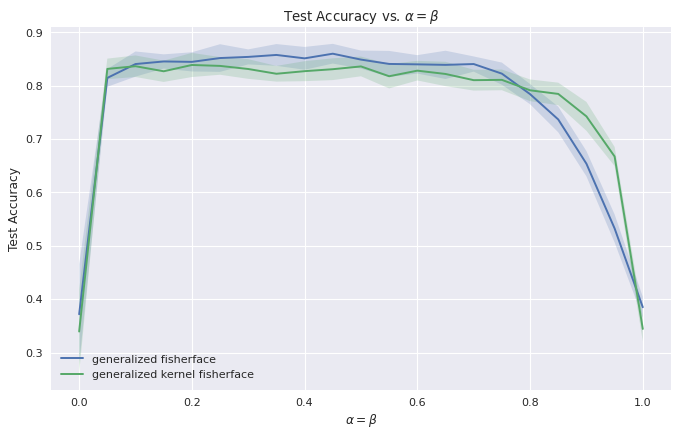

In [11]:
n_std = 1 # number of standard deviations for error bands
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,6), dpi=80);

# generalized fisherface
ax.plot(alpha_betas, fisher_acc_avg, label='generalized fisherface'); # line of avg test acc
ax.fill_between(alpha_betas, fisher_acc_avg - n_std * fisher_acc_std, fisher_acc_avg + n_std * fisher_acc_std, alpha=0.2) # estimate of error

# kernel generalized fisherface
ax.plot(alpha_betas, kfisher_acc_avg, label='generalized kernel fisherface'); # line of avg test acc
ax.fill_between(alpha_betas, kfisher_acc_avg - n_std * kfisher_acc_std, kfisher_acc_avg + n_std * kfisher_acc_std, alpha=0.2) # estimate of error

ax.set_title('Test Accuracy vs. $\\alpha = \\beta$');
ax.set_xlabel('$\\alpha=\\beta$');
ax.set_ylabel('Test Accuracy');

ax.legend()

In [13]:
data_dict = {'alpha_betas': alpha_betas, 'fisher_results': fisher_results, 'kernel_fisher_results': kernel_fisher_results}
np.save('results.npy', data_dict)